# MPC as tracking controller

In [1]:
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

In [ ]:
# ========================
# SYSTEM PARAMETERS
# ========================
mu_max = 0.86988      # 1/h
Ks = 0.000123762      # g/L
Yxs = 0.435749        # g/g
Sin = 286.0           # g/L
V0 = 1.7              # L, initial volume
X0 = 4.9              # g/L, initial biomass
S0 = 1.673            # g/L, initial substrate
F0 = 0.1              # L/h
K_I = 33              # Inhibition constant
K_D = 0.03            # Decay coefficient



In [465]:
# ========================
# MODEL DEFINITIONS
# ========================
def Euler(X,S,V,F,h,dt):
    Xcurrent,Scurrent,Vcurrent=X,S,V
    Fcurrent=F
    Num=int(dt/h)
    for i in range(Num):
        # Update time
        t = i * h
        
        # Calculate next state using Euler method
        Xnext, Snext, Vnext = euler_step(Xcurrent, Scurrent, Vcurrent, Fcurrent, h)
        
        # Update current state for next iteration
        Xcurrent, Scurrent, Vcurrent = Xnext, Snext, Vnext
    return Xcurrent, Scurrent, Vcurrent

def euler_step(Xcurrent, Scurrent, Vcurrent, Fcurrent, h):
    derivatives = plant_model(0, [Xcurrent, Scurrent, Vcurrent], Fcurrent)
    # Update each state with its corresponding derivative
    Xnext = Xcurrent + h * derivatives[0]  # dX_dt
    Snext = Scurrent + h * derivatives[1]  # dS_dt
    Vnext = Vcurrent + h * derivatives[2]  # dV_dt
    return Xnext, Snext, Vnext

def plant_model(t, y, F):
    """Controller's simplified model"""
    X, S, V = y
    S = np.maximum(S, 0)  # Prevent negative substrate
    
    # Simplified growth model (no inhibition/decay)
    mu = mu_max * S / (Ks + S)
    dX_dt = mu * X - (F/V) * X
    dS_dt = -(1/Yxs) * mu * X + (F/V)*(Sin - S)
    dV_dt = F
    
    return np.array([dX_dt, dS_dt, dV_dt])

def actual_model(t, y, F):
    """Real system dynamics"""
    X, S, V = y
    S = max(S,0)  # Prevent negative substrate 
    # True growth model with inhibition and decay
    mu = mu_max * S / (Ks + S + S**2/K_I)
    dX_dt = mu * X - (F/V) * X - K_D * X
    dS_dt = -(1/Yxs) * mu * X + (F/V)*(Sin - S)
    dV_dt = F
    
    return np.array([dX_dt, dS_dt, dV_dt])

# ========================
# DISCRETIZED MODEL (RK4)
# ========================
def discrete_model(t_start, X, S, V, F, h, dt):
    """RK4 integration with time awareness"""
    Num = int(dt/h)
    t = t_start
    X_curr, S_curr, V_curr = X, S, V
    
    for _ in range(Num):
        k1 = h*plant_model(t, [X_curr, S_curr, V_curr], F)
        k2 = h*plant_model(t + h/2, [
            X_curr + k1[0]*h/2,
            S_curr + k1[1]*h/2,
            V_curr + k1[2]*h/2
        ], F)
        k3 = h*plant_model(t + h/2, [
            X_curr + k2[0]*h/2,
            S_curr + k2[1]*h/2,
            V_curr + k2[2]*h/2
        ], F)
        k4 = h*plant_model(t + h, [
            X_curr + k3[0]*h,
            S_curr + k3[1]*h,
            V_curr + k3[2]*h
        ], F)

        X_next = X_curr + (h/6)*(k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        S_next = S_curr + (h/6)*(k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        V_next = V_curr + (h/6)*(k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        
        X_curr, S_curr, V_curr = X_next, S_next, V_next
        t += h
        
    return X_curr, S_curr, V_curr

# ========================
# SETPOINT FUNCTION
# ========================
def Cb_set(t):
    return 25  # Constant setpoint

# ========================
# COST FUNCTION
# ========================
def cost_function(F_opt, X, S, V, current_time,method="Euler"):
    J = 0
    X_curr, S_curr, V_curr = X, S, V
    
    for k in range(Np):
        pred_time = current_time + k*dt
        Cb_target = Cb_set(pred_time)
        
        if method=="Euler":
            # Predict next state using Euler method
            X_next, S_next, V_next = Euler(X_curr, S_curr, V_curr, F_opt[k], h, dt)
        else:
             # Predict next state using controller's model
            X_next, S_next, V_next = discrete_model(
            pred_time, X_curr, S_curr, V_curr, F_opt[k], h, dt
        )
        
        # Tracking error cost
        J += Q * (Cb_target - X_next)**2
        
        # Control smoothness cost
        if k > 0:
            J += R * (F_opt[k] - F_opt[k-1])**2
            
        X_curr, S_curr, V_curr = X_next, S_next, V_next
    
    return J

In [528]:
# ========================
# MPC SIMULATION SETUP
# ========================

# ========================
# MPC PARAMETERS
# ========================
dt = 0.1              # Control interval time (h)
Q = 0.1             # State tracking weight
R = 3              # Control effort weight
h = 0.01              # integration step size
At = 6                # Total simulation time (h)
Np = 12            # Prediction horizon steps
bnds = [(0, 0.1) for _ in range(Np)]  # Control input bounds

# Calculate simulation steps
SS = int(At/dt)
np.random.seed(0)    # For reproducibility

# Initialize arrays
X = np.zeros(SS+1)
S = np.zeros(SS+1)
V = np.zeros(SS+1)
F = np.zeros(SS)
X[0], S[0], V[0] = X0, S0, V0

# ========================
# MPC MAIN LOOP
# ========================
for step in range(SS):
    current_time = step * dt
    
    # Simulate measurement with noise
    X_measured = X[step] + np.random.normal(0, 1)
    
    # Solve MPC optimization
    res = minimize(
        cost_function,
        F0 * np.ones(Np),
        args=(X_measured, S[step], V[step], current_time),
        bounds=bnds,
        method="SLSQP",
    )
    
    # Apply first control input
    F[step] = res.x[0]
    
    # Simulate real system with actual model
    sol = solve_ivp(
        actual_model,
        [current_time, current_time + dt],
        [X[step], S[step], V[step]],
        args=(F[step],),
        t_eval=[current_time,current_time + dt],
    )
    X[step+1], S[step+1], V[step+1] = sol.y[:, -1]



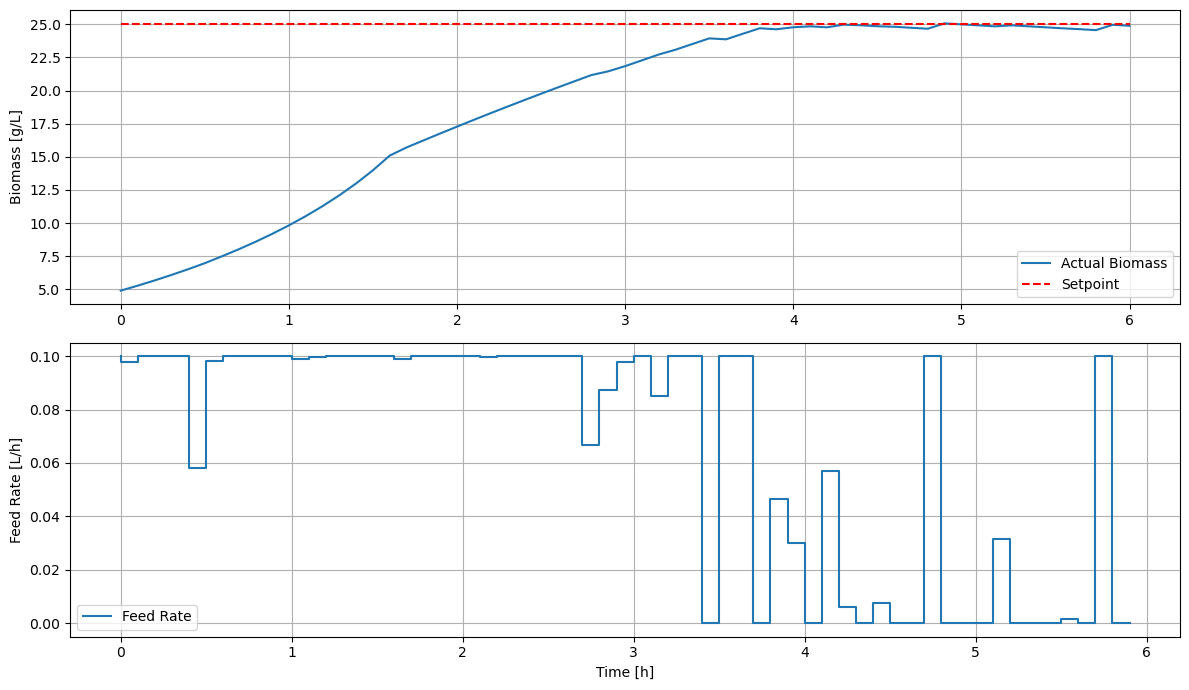

In [529]:
# ========================
# VISUALIZATION
# ========================
fig, axs = plt.subplots(2, 1, figsize=(12, 7))

# Biomass plot
time_axis = np.arange(0, At + dt, dt)
axs[0].plot(time_axis, X, label='Actual Biomass')
axs[0].step(time_axis, [Cb_set(t) for t in time_axis], 'r--', label='Setpoint')
axs[0].set_ylabel('Biomass [g/L]')
axs[0].legend()
axs[0].grid()

# Feed rate plot
axs[1].step(np.arange(0, At, dt), F, label='Feed Rate')
axs[1].set_xlabel('Time [h]')
axs[1].set_ylabel('Feed Rate [L/h]')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

In [495]:
X

array([ 4.9       ,  5.27146197,  5.66247998,  6.07496862,  6.5099339 ,
        6.96952133,  7.45594689,  7.97179091,  8.52008203,  9.10440872,
        9.72906916, 10.39927708, 11.12145105, 11.90363272, 12.75611133,
       13.69239355, 14.73078115, 15.89700115, 16.51312914, 17.03498719,
       17.54953574, 18.05689532, 18.55718339, 19.05051625, 19.53700558,
       20.01676262, 20.48989531, 20.9557987 , 21.4160086 , 21.86990553,
       22.31758949, 22.75915812, 22.69104213, 23.12707317, 23.5572316 ,
       23.98155061, 24.37153577, 24.78480614, 25.19249862, 25.59469734,
       25.99148589, 26.38294609, 26.7691583 , 26.68902951, 27.07063175,
       26.98959981, 27.36672608, 27.73888228, 27.65584852, 28.02362664,
       28.38657596, 28.3016019 , 28.66032242, 29.01435051, 29.36369602,
       29.70842792, 30.04861332, 30.38431703, 30.71560498, 31.04253857,
       31.36518205])

In [ ]:
# ========================
# DATA EXPORT
# ========================
MPC_data=[X,S,V,F]
MPC_df=pd.DataFrame(data=MPC_data).T
MPC_df.columns=["Biomass","Substrate","Volume","Feed"]   

In [122]:
k_string = ''.join(map(str, k))
k_string

'123'

In [130]:
s_k=""
for i in k:
    s_k+=str(i)

In [187]:
k=[1,2,3,4,5,6,7,8,9]
ath=1+k

TypeError: unsupported operand type(s) for +: 'int' and 'list'